## Input

A very basic model that returns the average delay across the training set for all inference requests

In [75]:
import gc
from itertools import cycle
import pickle

from feature_engine.creation import CyclicalFeatures
from feature_engine.encoding import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
# plot style
plt.style.use(['science','no-latex'])

# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['savefig.format'] = 'eps'
plt.rcParams['figure.figsize'] = (6, 3)

# display all rows and columns when printing in the notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# dtypes = {
#     'DayOfWeek':                       int,
#     'FlightDate':                      'string',
#     'IATA_CODE_Reporting_Airline':     'string',
#     'Tail_Number':                     'string',
#     'Flight_Number_Reporting_Airline': int,
#     'OriginAirportID':                 int,
#     'Origin':                          'string',
#     'OriginState':                     'string',
#     'DestAirportID':                   int,
#     'Dest':                            'string',
#     'DestState':                       'string',
#     'CRSDepTime':                      int,
#     'DepTime':                         int,
#     'DepDelayMinutes':                 int,
#     'CRSArrTime':                      int,
#     'ArrTime':                         int,
#     'ArrDelayMinutes':                 int,
#     'Cancelled':                       int,
#     'CancellationCode':                'string',
#     'Diverted':                        int,
#     'CRSElapsedTime':                  int,
#     'ActualElapsedTime':               int,
#     'AirTime':                         int,
#     'CarrierDelay':                    int,
#     'WeatherDelay':                    int,
#     'NASDelay':                        int,
#     'SecurityDelay':                   int,
#     'LateAircraftDelay':               int,
#     'CRSDepHour':                      int,
#     'OriginTz':                        'string',
#     'DestTz':                          'string',
#     'CRSArrDateTime':                  'string',
#     'CRSArrDate':                      'string',
#     'CRSArrHour':                      int,
#     'o_temperature_2m':                float,
#     'o_relative_humidity_2m':          float,
#     'o_dew_point_2m':                  float,
#     'o_apparent_temperature':          float,
#     'o_precipitation':                 float,
#     'o_rain':                          float,
#     'o_snowfall':                      float,
#     'o_snow_depth':                    float,
#     'o_weather_code':                  float,
#     'o_surface_pressure':              float,
#     'o_cloud_cover':                   float,
#     'o_cloud_cover_low':               float,
#     'o_cloud_cover_mid':               float,
#     'o_cloud_cover_high':              float,
#     'o_wind_speed_10m':                float,
#     'o_wind_speed_100m':               float,
#     'o_wind_gusts_10m':                float,
#     'o_shortwave_radiation':           float,
#     'o_direct_radiation':              float,
#     'o_diffuse_radiation':             float,
#     'o_direct_normal_irradiance':      float,
#     'o_terrestrial_radiation':         float,
#     'o_airport':                       'string',
#     'o_day':                           'string',
#     'o_hour':                          int,
#     'd_temperature_2m':                float,
#     'd_relative_humidity_2m':          float,
#     'd_dew_point_2m':                  float,
#     'd_apparent_temperature':          float,
#     'd_precipitation':                 float,
#     'd_rain':                          float,
#     'd_snowfall':                      float,
#     'd_snow_depth':                    float,
#     'd_weather_code':                  float,
#     'd_surface_pressure':              float,
#     'd_cloud_cover':                   float,
#     'd_cloud_cover_low':               float,
#     'd_cloud_cover_mid':               float,
#     'd_cloud_cover_high':              float,
#     'd_wind_speed_10m':                float,
#     'd_wind_speed_100m':               float,
#     'd_wind_gusts_10m':                float,
#     'd_shortwave_radiation':           float,
#     'd_direct_radiation':              float,
#     'd_diffuse_radiation':             float,
#     'd_direct_normal_irradiance':      float,
#     'd_terrestrial_radiation':         float,
#     'd_airport':                       'string',
#     'd_day':                           'string',
#     'd_hour':                          int
# }

def load_data():
    files = [
        'data/weather-joined/full-w-2017.csv',
        'data/weather-joined/full-w-2018.csv',
        'data/weather-joined/full-w-2019.csv',
    ]

    dfs = [pd.read_csv(f, low_memory=False) for f in files]
    return pd.concat(dfs, ignore_index=True)

In [4]:
df = load_data()

In [5]:
df.shape[0]

19127490

In [6]:
def clean_data(df):
    # convert string timestamps to datetime objects
    datetime_cols = ['FlightDate', 'CRSArrDateTime', 'CRSArrDate', 'o_day', 'd_day']
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col])

    # drop rows that have cancelled or diverted flights
    df = df.drop(df[(df['Cancelled'] == 1) | (df['Diverted'] == 1)].index)

    # fill 0s for columns that make sense
    cols = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "o_snow_depth", "d_snow_depth"]
    df[cols] = df[cols].fillna(value=0)

    # we won't use `CancellationCode`, so drop it
    df = df.drop('CancellationCode', axis=1)

    # drop rows that have `NaN`s for the other columns.
    df = df.dropna()
    
    return df

In [7]:
df = clean_data(df)
df.shape[0]

/tmp/ipykernel_163045/1114253781.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[col] = pd.to_datetime(df[col])


18770048

In [8]:
df.isnull().sum()

DayOfWeek                          0
FlightDate                         0
IATA_CODE_Reporting_Airline        0
Tail_Number                        0
Flight_Number_Reporting_Airline    0
OriginAirportID                    0
Origin                             0
OriginState                        0
DestAirportID                      0
Dest                               0
DestState                          0
CRSDepTime                         0
DepTime                            0
DepDelayMinutes                    0
CRSArrTime                         0
ArrTime                            0
ArrDelayMinutes                    0
Cancelled                          0
Diverted                           0
CRSElapsedTime                     0
ActualElapsedTime                  0
AirTime                            0
CarrierDelay                       0
WeatherDelay                       0
NASDelay                           0
SecurityDelay                      0
LateAircraftDelay                  0
C

In [9]:
mask = (df['WeatherDelay'] > 0) | (df['NASDelay'] > 0)
df = df[mask]
df['delay'] = df['WeatherDelay'] + df['NASDelay']

In [10]:
df['delay'].describe()

count    2.028896e+06
mean     3.460624e+01
std      5.847412e+01
min      1.000000e+00
25%      9.000000e+00
50%      1.900000e+01
75%      3.700000e+01
max      2.692000e+03
Name: delay, dtype: float64

In [113]:
df.shape[0]

2028896

In [13]:
df['delay'].quantile(0.95)

117.0

array([[<Axes: title={'center': 'delay'}>]], dtype=object)

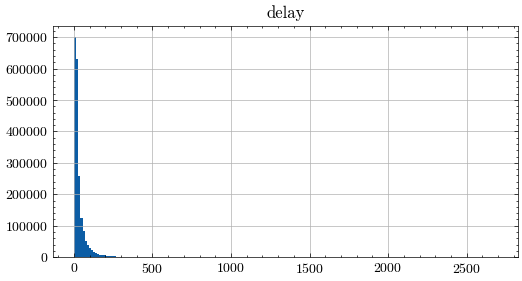

In [14]:
df.hist('delay', bins=200)

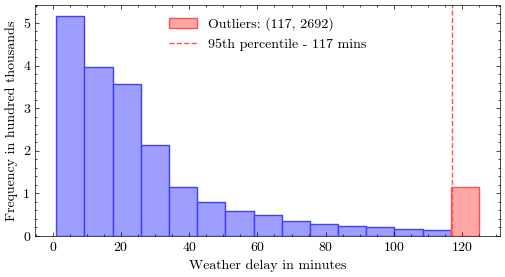

In [112]:
fig, ax = plt.subplots()

n, bins, patches = ax.hist(df['delay'], bins=15, range=(df['delay'].min(), 125), ec="#3f3fff", linewidth=1, fc="#9e9eff")

n_upper_outliers = (df['delay'] > 117).sum()
patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
patches[-1].set_facecolor("#ffa7a7")
patches[-1].set_edgecolor("#ff5151")
patches[-1].set_label('Outliers: ({:.0f}, {:.0f})'.format(117, df['delay'].max()))

ax.axvline(df['delay'].quantile(0.95), color="#ff5151", linestyle='dashed', label="95th percentile - 117 mins")

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '%.0f' % (y * 1e-5)))

plt.ylabel("Frequency in hundred thousands")
plt.xlabel("Weather delay in minutes")
plt.legend()
plt.savefig("delay-dist.eps", bbox_inches="tight")

plt.show()

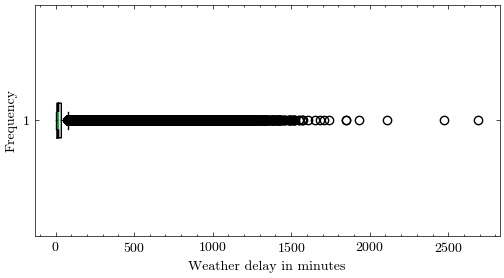

In [19]:
plt.boxplot(df['delay'], notch=True, vert=False)
            

plt.ylabel("Frequency")
plt.xlabel("Weather delay in minutes")
# plt.savefig("delay-dist.eps", bbox_inches="tight")

plt.show()

In [2]:
dtypes = {
    'DayOfWeek':                       int,
    'FlightDate':                      'string',
    'IATA_CODE_Reporting_Airline':     'string',
    'Tail_Number':                     'string',
    'Flight_Number_Reporting_Airline': int,
    'OriginAirportID':                 int,
    'Origin':                          'string',
    'OriginState':                     'string',
    'DestAirportID':                   int,
    'Dest':                            'string',
    'DestState':                       'string',
    'CRSDepTime':                      int,
    'DepTime':                         int,
    'DepDelayMinutes':                 int,
    'CRSArrTime':                      int,
    'ArrTime':                         int,
    'ArrDelayMinutes':                 int,
    'CRSElapsedTime':                  int,
    'ActualElapsedTime':               int,
    'AirTime':                         int,
    'Cancelled':                       int,
    'CancellationCode':                'string',
    'Diverted':                        int,
    'CarrierDelay':                    int,
    'WeatherDelay':                    int,
    'NASDelay':                        int,
    'SecurityDelay':                   int,
    'LateAircraftDelay':               int
}

In [3]:
files = [
    'data/weather-joined/full-w-2017.csv',
    'data/weather-joined/full-w-2018.csv',
]
# ddf_all = [dd.read_csv(path, dtype=dtypes) for path in files]
# ddf = dd.concat(ddf_all, ignore_index=True)
# df = ddf.compute()
# df

In [4]:
df17 = pd.read_csv('data/weather-joined/full-w-2017.csv')

/tmp/ipykernel_160888/1019346317.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df17 = pd.read_csv('data/weather-joined/full-w-2017.csv')


In [ ]:
df18 = pd.read_csv('data/weather-joined/full-w-2018.csv')

/tmp/ipykernel_8094/4125061346.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df18 = pd.read_csv('data/weather-joined/full-w-2018.csv')


In [ ]:
df19 = pd.read_csv('data/weather-joined/full-w-2019.csv')

In [8]:
delay_df = pd.DataFrame()
non_delay_df = pd.DataFrame()
chunkcount = 0

for chunk in df17:
    delay_chunk = chunk[(chunk['WeatherDelay'] > 0) | (chunk['NASDelay'] > 0)]
    delay_df = pd.concat([delay_df, delay_chunk])

    if non_delay_df.shape[0] < 600000:
        non_delay_chunk = chunk[(chunk['DepDelayMinutes'] == 0) & (chunk['Cancelled'] == 0)]
        non_delay_df = pd.concat([non_delay_df, non_delay_chunk])
    chunkcount += 1
    print(f'Chunk {chunkcount}: Delay - {delay_df.shape[0]}, Nondelay - {non_delay_df.shape[0]}')

Chunk 1: Delay - 13152, Nondelay - 63823
Chunk 2: Delay - 26597, Nondelay - 122357
Chunk 3: Delay - 37714, Nondelay - 185442


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 4: Delay - 50954, Nondelay - 246459


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 5: Delay - 61359, Nondelay - 308739
Chunk 6: Delay - 68918, Nondelay - 382933
Chunk 7: Delay - 78690, Nondelay - 447325
Chunk 8: Delay - 89012, Nondelay - 509427


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 9: Delay - 99668, Nondelay - 580408


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 10: Delay - 110757, Nondelay - 644507
Chunk 11: Delay - 121802, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 12: Delay - 132367, Nondelay - 644507
Chunk 13: Delay - 142458, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 14: Delay - 154026, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 15: Delay - 163964, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 16: Delay - 176363, Nondelay - 644507
Chunk 17: Delay - 188567, Nondelay - 644507
Chunk 18: Delay - 199029, Nondelay - 644507
Chunk 19: Delay - 210984, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 20: Delay - 221260, Nondelay - 644507
Chunk 21: Delay - 233027, Nondelay - 644507
Chunk 22: Delay - 244754, Nondelay - 644507
Chunk 23: Delay - 256529, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 24: Delay - 269347, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 25: Delay - 281419, Nondelay - 644507
Chunk 26: Delay - 292443, Nondelay - 644507
Chunk 27: Delay - 305906, Nondelay - 644507
Chunk 28: Delay - 319163, Nondelay - 644507
Chunk 29: Delay - 330105, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 30: Delay - 341231, Nondelay - 644507
Chunk 31: Delay - 354110, Nondelay - 644507
Chunk 32: Delay - 365253, Nondelay - 644507
Chunk 33: Delay - 378520, Nondelay - 644507
Chunk 34: Delay - 391779, Nondelay - 644507
Chunk 35: Delay - 403881, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 36: Delay - 416263, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 37: Delay - 424027, Nondelay - 644507
Chunk 38: Delay - 435166, Nondelay - 644507
Chunk 39: Delay - 442456, Nondelay - 644507
Chunk 40: Delay - 449603, Nondelay - 644507
Chunk 41: Delay - 457137, Nondelay - 644507
Chunk 42: Delay - 465179, Nondelay - 644507
Chunk 43: Delay - 472133, Nondelay - 644507
Chunk 44: Delay - 479757, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 45: Delay - 486213, Nondelay - 644507
Chunk 46: Delay - 493387, Nondelay - 644507
Chunk 47: Delay - 502699, Nondelay - 644507
Chunk 48: Delay - 509839, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 49: Delay - 514707, Nondelay - 644507
Chunk 50: Delay - 522256, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 51: Delay - 529255, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 52: Delay - 534471, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 53: Delay - 542728, Nondelay - 644507
Chunk 54: Delay - 553880, Nondelay - 644507
Chunk 55: Delay - 562001, Nondelay - 644507


/tmp/ipykernel_8094/2487617861.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in df17:


Chunk 56: Delay - 572541, Nondelay - 644507
Chunk 57: Delay - 580926, Nondelay - 644507


In [5]:
# print(df17.isna().sum())
delay_df = df17[(df17['WeatherDelay'] > 0) | (df17['NASDelay'] > 0)]

In [5]:
cancelled_df = df17[df17['Cancelled'] == 1]

In [6]:
non_delay_df = df17[(df17['DepDelayMinutes'] + df17['ArrDelayMinutes'] == 0) & (df17['Cancelled'] == 0) & (df17['Diverted'] == 0)]

In [6]:
delay_df['delay'] = delay_df['WeatherDelay'] + delay_df['NASDelay']

/tmp/ipykernel_160888/2559233685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_df['delay'] = delay_df['WeatherDelay'] + delay_df['NASDelay']


In [9]:
print(delay_df['delay'].describe())
delay_df['delay'].quantile(0.95)

count    580926.000000
mean         33.223760
std          53.040744
min           1.000000
25%           9.000000
50%          19.000000
75%          36.000000
max        1934.000000
Name: delay, dtype: float64


115.0

array([[<Axes: title={'center': 'delay'}>]], dtype=object)

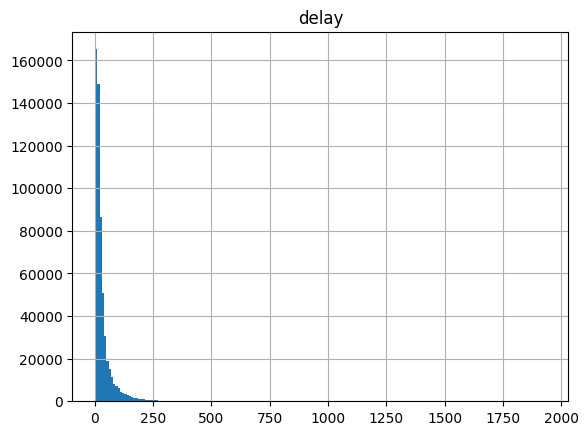

In [19]:
delay_df.hist('delay', bins=200)

In [24]:
cancelled_df.shape

(82693, 84)

In [8]:
non_delay_df.isnull().sum()

DayOfWeek                                0
FlightDate                               0
IATA_CODE_Reporting_Airline              0
Tail_Number                              0
Flight_Number_Reporting_Airline          0
OriginAirportID                          0
Origin                                   0
OriginState                              0
DestAirportID                            0
Dest                                     0
DestState                                0
CRSDepTime                               0
DepTime                                  0
DepDelayMinutes                          0
CRSArrTime                               0
ArrTime                                  0
ArrDelayMinutes                          0
Cancelled                                0
CancellationCode                   3095506
Diverted                                 0
CRSElapsedTime                           0
ActualElapsedTime                        0
AirTime                                  0
CarrierDela

In [17]:
non_delay_df[non_delay_df["ActualElapsedTime"].isna()]["Cancelled"].value_counts()

Series([], Name: count, dtype: int64)

In [7]:
# fill 0s for columns that make sense
cols = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "o_snow_depth", "d_snow_depth"]
non_delay_df[cols] = non_delay_df[cols].fillna(value=0)
print(non_delay_df.isna().sum())

delay_df[cols] = delay_df[cols].fillna(value=0)
print(non_delay_df.isna().sum())

/tmp/ipykernel_50426/1550469271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_delay_df[cols] = non_delay_df[cols].fillna(value=0)


DayOfWeek                                0
FlightDate                               0
IATA_CODE_Reporting_Airline              0
Tail_Number                              0
Flight_Number_Reporting_Airline          0
OriginAirportID                          0
Origin                                   0
OriginState                              0
DestAirportID                            0
Dest                                     0
DestState                                0
CRSDepTime                               0
DepTime                                  0
DepDelayMinutes                          0
CRSArrTime                               0
ArrTime                                  0
ArrDelayMinutes                          0
Cancelled                                0
CancellationCode                   3095506
Diverted                                 0
CRSElapsedTime                           0
ActualElapsedTime                        0
AirTime                                  0
CarrierDela

/tmp/ipykernel_50426/1550469271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_df[cols] = delay_df[cols].fillna(value=0)


DayOfWeek                                0
FlightDate                               0
IATA_CODE_Reporting_Airline              0
Tail_Number                              0
Flight_Number_Reporting_Airline          0
OriginAirportID                          0
Origin                                   0
OriginState                              0
DestAirportID                            0
Dest                                     0
DestState                                0
CRSDepTime                               0
DepTime                                  0
DepDelayMinutes                          0
CRSArrTime                               0
ArrTime                                  0
ArrDelayMinutes                          0
Cancelled                                0
CancellationCode                   3095506
Diverted                                 0
CRSElapsedTime                           0
ActualElapsedTime                        0
AirTime                                  0
CarrierDela

## Baseline model

A very basic model that returns the average delay across the training set for all inference requests

In [8]:
feature_columns = delay_df.columns.tolist()
print(feature_columns)

['DayOfWeek', 'FlightDate', 'IATA_CODE_Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'OriginAirportID', 'Origin', 'OriginState', 'DestAirportID', 'Dest', 'DestState', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'CRSArrTime', 'ArrTime', 'ArrDelayMinutes', 'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CRSDepHour', 'OriginTz', 'DestTz', 'CRSArrDateTime', 'CRSArrDate', 'CRSArrHour', 'o_temperature_2m', 'o_relative_humidity_2m', 'o_dew_point_2m', 'o_apparent_temperature', 'o_precipitation', 'o_rain', 'o_snowfall', 'o_snow_depth', 'o_weather_code', 'o_surface_pressure', 'o_cloud_cover', 'o_cloud_cover_low', 'o_cloud_cover_mid', 'o_cloud_cover_high', 'o_wind_speed_10m', 'o_wind_speed_100m', 'o_wind_gusts_10m', 'o_shortwave_radiation', 'o_direct_radiation', 'o_diffuse_radiation', 'o_direct_normal_irradiance', 'o_terrestrial_radiation', 'o_a

In [9]:
numeric_columns = delay_df.select_dtypes(['number']).columns.tolist()
print(numeric_columns)

numeric_features = ['o_temperature_2m', 'o_relative_humidity_2m', 'o_dew_point_2m', 'o_apparent_temperature', 'o_precipitation', 'o_rain', 'o_snowfall', 'o_snow_depth', 'o_surface_pressure', 'o_cloud_cover', 'o_cloud_cover_low', 'o_cloud_cover_mid', 'o_cloud_cover_high', 'o_wind_speed_10m', 'o_wind_speed_100m', 'o_wind_gusts_10m', 'o_shortwave_radiation', 'o_direct_radiation', 'o_diffuse_radiation', 'o_direct_normal_irradiance', 'o_terrestrial_radiation']
target_feature = ['DepDelayMinutes']#, 'WeatherDelay', 'NASDelay']

d_numeric_features = ['d_temperature_2m', 'd_relative_humidity_2m', 'd_dew_point_2m', 'd_apparent_temperature', 'd_precipitation', 'd_rain', 'd_snowfall', 'd_snow_depth', 'd_surface_pressure', 'd_cloud_cover', 'd_cloud_cover_low', 'd_cloud_cover_mid', 'd_cloud_cover_high', 'd_wind_speed_10m', 'd_wind_speed_100m', 'd_wind_gusts_10m', 'd_shortwave_radiation', 'd_direct_radiation', 'd_diffuse_radiation', 'd_direct_normal_irradiance', 'd_terrestrial_radiation']
d_target_feature = ['ArrDelayMinutes']#, 'WeatherDelay', 'NASDelay']

['DayOfWeek', 'Flight_Number_Reporting_Airline', 'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'CRSArrTime', 'ArrTime', 'ArrDelayMinutes', 'Cancelled', 'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CRSDepHour', 'CRSArrHour', 'o_temperature_2m', 'o_relative_humidity_2m', 'o_dew_point_2m', 'o_apparent_temperature', 'o_precipitation', 'o_rain', 'o_snowfall', 'o_snow_depth', 'o_weather_code', 'o_surface_pressure', 'o_cloud_cover', 'o_cloud_cover_low', 'o_cloud_cover_mid', 'o_cloud_cover_high', 'o_wind_speed_10m', 'o_wind_speed_100m', 'o_wind_gusts_10m', 'o_shortwave_radiation', 'o_direct_radiation', 'o_diffuse_radiation', 'o_direct_normal_irradiance', 'o_terrestrial_radiation', 'o_hour', 'd_temperature_2m', 'd_relative_humidity_2m', 'd_dew_point_2m', 'd_apparent_temperature', 'd_precipitation', 'd_rain', 'd_snowfall', 'd_snow_depth', 'd_weather_code', 'd_surf

In [10]:
num_delay_records = delay_df.shape[0]
model_df = pd.concat([delay_df, non_delay_df.sample(num_delay_records, replace=False)])
print(model_df.shape)

(1161852, 84)


In [11]:
model_df[cols] = model_df[cols].fillna(value=0)
print(model_df.isna().sum())

model_df.isnull().sum()

DayOfWeek                                0
FlightDate                               0
IATA_CODE_Reporting_Airline              0
Tail_Number                              0
Flight_Number_Reporting_Airline          0
OriginAirportID                          0
Origin                                   0
OriginState                              0
DestAirportID                            0
Dest                                     0
DestState                                0
CRSDepTime                               0
DepTime                                  0
DepDelayMinutes                          0
CRSArrTime                               0
ArrTime                                  0
ArrDelayMinutes                          0
Cancelled                                0
CancellationCode                   1161852
Diverted                                 0
CRSElapsedTime                           0
ActualElapsedTime                        0
AirTime                                  0
CarrierDela

DayOfWeek                                0
FlightDate                               0
IATA_CODE_Reporting_Airline              0
Tail_Number                              0
Flight_Number_Reporting_Airline          0
OriginAirportID                          0
Origin                                   0
OriginState                              0
DestAirportID                            0
Dest                                     0
DestState                                0
CRSDepTime                               0
DepTime                                  0
DepDelayMinutes                          0
CRSArrTime                               0
ArrTime                                  0
ArrDelayMinutes                          0
Cancelled                                0
CancellationCode                   1161852
Diverted                                 0
CRSElapsedTime                           0
ActualElapsedTime                        0
AirTime                                  0
CarrierDela

In [87]:

#encoding string data to numeric
label_encoder = LabelEncoder()
feature_columns_1 = ['CRSDepTime', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m', 'shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance', 'terrestrial_radiation']


In [52]:
model_df = model_df.sample(frac=1).reset_index(drop=True) #Shuffling dataset

In [53]:
model_df.head()

,DayOfWeek,FlightDate,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,Origin,OriginState,DestAirportID,Dest,DestState,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSDepHour,OriginTz,DestTz,CRSArrDateTime,CRSArrDate,CRSArrHour,o_temperature_2m,o_relative_humidity_2m,o_dew_point_2m,o_apparent_temperature,o_precipitation,o_rain,o_snowfall,o_snow_depth,o_weather_code,o_surface_pressure,o_cloud_cover,o_cloud_cover_low,o_cloud_cover_mid,o_cloud_cover_high,o_wind_speed_10m,o_wind_speed_100m,o_wind_gusts_10m,o_shortwave_radiation,o_direct_radiation,o_diffuse_radiation,o_direct_normal_irradiance,o_terrestrial_radiation,o_airport,o_day,o_hour,d_temperature_2m,d_relative_humidity_2m,d_dew_point_2m,d_apparent_temperature,d_precipitation,d_rain,d_snowfall,d_snow_depth,d_weather_code,d_surface_pressure,d_cloud_cover,d_cloud_cover_low,d_cloud_cover_mid,d_cloud_cover_high,d_wind_speed_10m,d_wind_speed_100m,d_wind_gusts_10m,d_shortwave_radiation,d_direct_radiation,d_diffuse_radiation,d_direct_normal_irradiance,d_terrestrial_radiation,d_airport,d_day,d_hour
0,1,2017-08-21,AS,N593AS,507,14908,SNA,CA,14747,SEA,WA,1545,1540.0,0.0,1822,1818.0,0.0,0,NaN,0,157.0,158.0,133.0,0.0,0.0,0.0,0.0,0.0,15,America/Los_Angeles,America/Los_Angeles,2017-08-21 18:22:00-07:53,2017-08-21,18,67.423996,77.967064,60.314003,70.518470,0.000000,0.000000,0.0,0.0,0.0,1014.14250,11.7,13.0,0.0,0.0,1.000417,1.000417,5.8162,157.0,96.0,61.0,399.72626,321.04938,SNA,2017-08-21,15,68.5724,63.306793,55.612400,67.232370,0.000000,0.000000,0.0,0.0,0.0,1005.29540,15.3,0.0,0.0,51.0,8.795707,11.205114,18.567100,611.0,509.0,102.0,779.311340,873.15730,SEA,2017-08-21,18
1,3,2017-03-08,UA,N838UA,1910,14492,RDU,NC,11292,DEN,CO,1608,1608.0,0.0,1815,1844.0,29.0,0,NaN,0,247.0,276.0,218.0,0.0,0.0,29.0,0.0,0.0,15,America/New_York,America/Denver,2017-03-08 18:11:00-07:00,2017-03-08,17,56.551098,43.639710,34.681100,50.268690,0.000000,0.000000,0.0,0.0,2.0,1009.47790,69.3,11.0,99.0,0.0,6.847559,9.827536,16.1064,201.0,23.0,178.0,43.25597,738.41583,RDU,2017-03-08,15,54.5918,20.792200,15.171801,46.305730,0.000000,0.000000,0.0,0.0,1.0,838.78220,33.3,9.0,15.0,54.0,6.203391,8.018950,16.330101,559.0,474.0,85.0,887.841200,741.38477,DEN,2017-03-08,17
2,6,2017-10-28,AA,N770AA,509,10397,ATL,GA,13303,MIA,FL,1230,1240.0,10.0,1426,1519.0,53.0,0,NaN,0,116.0,159.0,124.0,10.0,0.0,43.0,0.0,0.0,12,America/New_York,America/New_York,2017-10-28 14:36:00-04:56,2017-10-28,14,56.664500,87.145300,52.884500,53.485672,0.003937,0.003937,0.0,0.0,51.0,976.56130,82.5,4.0,86.0,91.0,9.637291,17.689281,18.5671,0.0,0.0,0.0,0.00000,0.00000,ATL,2017-10-28,12,78.5219,81.544420,72.401900,83.100174,0.011811,0.011811,0.0,0.0,51.0,1011.76890,61.5,2.0,50.0,99.0,11.205114,17.540134,19.014500,168.0,47.0,121.0,112.764150,577.74870,MIA,2017-10-28,14
3,4,2017-02-16,AA,N539AA,753,14843,SJU,PR,11057,CLT,NC,1720,1728.0,8.0,2018,2045.0,27.0,0,NaN,0,238.0,257.0,233.0,8.0,0.0,19.0,0.0,0.0,17,America/Puerto_Rico,America/New_York,2017-02-16 20:50:00-05:00,2017-02-16,20,83.366590,56.277700,66.176600,87.824100,0.007874,0.007874,0.0,0.0,51.0,1016.17285,76.5,17.0,55.0,94.0,8.858068,10.167897,20.8041,771.0,606.0,165.0,706.29346,1202.56310,SJU,2017-02-16,17,54.2030,25.869240,19.913000,44.537926,0.000000,0.000000,0.0,0.0,1.0,986.33716,22.2,0.0,10.0,54.0,11.340508,15.246103,25.278101,600.0,501.0,99.0,859.279050,817.15076,CLT,2017-02-16,20
4,3,2017-04-12,AA,N514AA,1286,11298,DFW,TX,13871,OMA,NE,1222,1434.0,132.0,1407,1626.0,139.0,0,NaN,0,105.0,112.0,90.0,132.0,0.0,7.0,0.0,0.0,12,America/Chicago,America/Chicago,2017-04-12 16:19:00-05:51,2017-04-12,16,63.645798,97.197200,62.835796,67.907326,0.000000,0.000000,0.0,0.0,3.0,1000.34210,100.0,100.0,0.0,70.0,0.707402,1.304384,3.8029,0.0,0.0,0.0,0.00000,0.00000,DFW,2017-04-12,12,58.6544,62.262950,45.784400,53.077442,0.00

In [54]:
from sklearn.model_selection import train_test_split

X = model_df[d_numeric_features]
Y = model_df['WeatherDelay'] + model_df['NASDelay']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

In [55]:
predictions_df = pd.DataFrame({'actual': Y_test})

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing  import LabelEncoder
from math import sqrt

model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)

predictions_df['baseline1'] = Y_pred

print(f'Root Mean Squared Error on Training Set: {rmse}')
print(f'Mean Absolute Error on Training Set: {mae}')

Root Mean Squared Error on Training Set: 39.7513079816823
Mean Absolute Error on Training Set: 19.483421525890513


In [60]:
# predictions_df[predictions_df['actual'] > 0].count()
# predictions_df.reset_index()
predictions_df.head()

,actual,baseline1
778440,0.0,30.729280
778441,43.0,14.416085
778442,0.0,8.692503
778443,0.0,4.805410
778444,20.0,14.336179


In [61]:
r2 = r2_score(Y_test, Y_pred)
print(f'R2 Score on Test Set: {r2}')

R2 Score on Test Set: 0.03792177426290466


In [73]:
# x_train_mean = df_dropped[feature_columns_1]
# df_dropped['target_variable_avg'] = df_dropped['target_variable'].mean()
# y_train_mean = df_dropped['target_variable_avg']
# model = LinearRegression()
# model.fit(x_train_mean, y_train_mean)
# x_test_mean = df3[feature_columns_1]
# y_test_mean = df3['target_variable']

Y_pred = pd.DataFrame()
train_mean = Y_train.mean()
print(train_mean)
Y_pred = pd.Series([train_mean for _ in range(len(Y_test.index))])

print(Y_pred.head())
# y_pred_mean = model.predict(x_test_mean)
mse = mean_squared_error(Y_test, Y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)

predictions_df['baseline0'] = train_mean

print(f'Root Mean Squared Error on Training Set: {rmse}')
print(f'Mean Absolute Error on Training Set: {mae}')

16.636534607676893
0    16.636535
1    16.636535
2    16.636535
3    16.636535
4    16.636535
dtype: float64
Root Mean Squared Error on Training Set: 40.527234418642756
Mean Absolute Error on Training Set: 20.270930849323125


In [74]:
predictions_df.head()

,actual,baseline1,baseline0
778440,0.0,30.729280,16.636535
778441,43.0,14.416085,16.636535
778442,0.0,8.692503,16.636535
778443,0.0,4.805410,16.636535
778444,20.0,14.336179,16.636535


## Model 1

In [75]:
non_numeric_columns = model_df.select_dtypes(exclude=['number']).columns.tolist()
print(model_df.columns)

Index(['DayOfWeek', 'FlightDate', 'IATA_CODE_Reporting_Airline', 'Tail_Number',
       'Flight_Number_Reporting_Airline', 'OriginAirportID', 'Origin',
       'OriginState', 'DestAirportID', 'Dest', 'DestState', 'CRSDepTime',
       'DepTime', 'DepDelayMinutes', 'CRSArrTime', 'ArrTime',
       'ArrDelayMinutes', 'Cancelled', 'CancellationCode', 'Diverted',
       'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'CRSDepHour', 'OriginTz', 'DestTz', 'CRSArrDateTime', 'CRSArrDate',
       'CRSArrHour', 'o_temperature_2m', 'o_relative_humidity_2m',
       'o_dew_point_2m', 'o_apparent_temperature', 'o_precipitation', 'o_rain',
       'o_snowfall', 'o_snow_depth', 'o_weather_code', 'o_surface_pressure',
       'o_cloud_cover', 'o_cloud_cover_low', 'o_cloud_cover_mid',
       'o_cloud_cover_high', 'o_wind_speed_10m', 'o_wind_speed_100m',
       'o_wind_gusts_10m', 'o_shortwave_radiation', 'o_direct

In [76]:
cols_to_drop = ['IATA_CODE_Reporting_Airline', 'Flight_Number_Reporting_Airline', 'Tail_Number', 'OriginState', 'DestState', 'FlightDate', 'OriginAirportID', 'DestAirportID', 'DepTime', 'CRSArrTime', 'ArrTime', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'SecurityDelay', 'LateAircraftDelay', 'CRSArrHour', 'CRSDepTime', 'd_airport', 'o_airport', 'OriginTz', 'DestTz', 'CRSArrDate']
model_df_dropped = model_df.drop(cols_to_drop, axis=1)

In [77]:
print(model_df_dropped.columns)

Index(['DayOfWeek', 'Origin', 'Dest', 'DepDelayMinutes', 'ArrDelayMinutes',
       'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'WeatherDelay',
       'NASDelay', 'CRSDepHour', 'CRSArrDateTime', 'o_temperature_2m',
       'o_relative_humidity_2m', 'o_dew_point_2m', 'o_apparent_temperature',
       'o_precipitation', 'o_rain', 'o_snowfall', 'o_snow_depth',
       'o_weather_code', 'o_surface_pressure', 'o_cloud_cover',
       'o_cloud_cover_low', 'o_cloud_cover_mid', 'o_cloud_cover_high',
       'o_wind_speed_10m', 'o_wind_speed_100m', 'o_wind_gusts_10m',
       'o_shortwave_radiation', 'o_direct_radiation', 'o_diffuse_radiation',
       'o_direct_normal_irradiance', 'o_terrestrial_radiation', 'o_day',
       'o_hour', 'd_temperature_2m', 'd_relative_humidity_2m',
       'd_dew_point_2m', 'd_apparent_temperature', 'd_precipitation', 'd_rain',
       'd_snowfall', 'd_snow_depth', 'd_weather_code', 'd_surface_pressure',
       'd_cloud_cover', 'd_cloud_cover_low', 'd_cloud_cover_mid'

In [78]:
import numpy as np 

def encode_cols(df):
    def procDate(day):
        return pd.Series([day.year, day.month])

    df_encoded = df.copy()
    df_encoded['weekend'] = df_encoded['DayOfWeek'] >= 6 #.apply(lambda x: pd.Series([x<6, x>=6]))
    df_encoded['o_day'] = df_encoded['o_day'].astype('datetime64[ns]')
    df_encoded['year'] = df_encoded['o_day'].dt.year
    df_encoded['month'] = df_encoded['o_day'].dt.month
    df_encoded['day'] = df_encoded['o_day'].dt.day
    df_encoded['xhr'] = np.sin(np.pi*df_encoded['o_hour']/12)
    df_encoded['yhr'] = np.cos(np.pi*df_encoded['o_hour']/12)
    
    df_encoded = df_encoded.drop(['DayOfWeek', 'o_day', 'o_hour'], axis=1)

    return df_encoded

model_df_encoded = encode_cols(model_df_dropped)

# delay_df_encoded = one_hot_encode(delay_df_encoded)

In [79]:
def one_hot_encode(df):
    one_hot_encoding_cols = ['o_weather_code'] #'Origin'
    df_encoded = pd.get_dummies(df, columns=one_hot_encoding_cols)
    return df_encoded
    
model_df_encoded = one_hot_encode(model_df_encoded)

In [125]:
model_df_encoded.columns

Index(['Dest', 'DepDelayMinutes', 'ArrDelayMinutes', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'WeatherDelay', 'NASDelay',
       'CRSDepHour', 'CRSArrDateTime',
       ...
       'Origin_TYS', 'Origin_UIN', 'Origin_UST', 'Origin_VLD', 'Origin_VPS',
       'Origin_WRG', 'Origin_WYS', 'Origin_XNA', 'Origin_YAK', 'Origin_YUM'],
      dtype='object', length=391)

In [80]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def scale_df(df):
    columns_to_scale = ['o_temperature_2m', 'o_relative_humidity_2m', 'o_dew_point_2m', 'o_apparent_temperature', 'o_precipitation', 'o_rain', 'o_snowfall', 'o_snow_depth', 'o_surface_pressure', 'o_cloud_cover', 'o_cloud_cover_low', 'o_cloud_cover_mid', 'o_cloud_cover_high', 'o_wind_speed_10m', 'o_wind_speed_100m', 'o_wind_gusts_10m', 'o_shortwave_radiation', 'o_direct_radiation', 'o_diffuse_radiation', 'o_direct_normal_irradiance', 'o_terrestrial_radiation']

    scaler = StandardScaler()

    scaled_data = df.copy()
    scaled_data[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    return scaled_data

model_df_scaled = scale_df(model_df_encoded)

In [78]:
model_df_scaled.describe()

,DepDelayMinutes,ArrDelayMinutes,CRSElapsedTime,ActualElapsedTime,AirTime,WeatherDelay,NASDelay,CRSDepHour,o_temperature_2m,o_relative_humidity_2m,o_dew_point_2m,o_apparent_temperature,o_precipitation,o_rain,o_snowfall,o_snow_depth,o_weather_code,o_surface_pressure,o_cloud_cover,o_cloud_cover_low,o_cloud_cover_mid,o_cloud_cover_high,o_wind_speed_10m,o_wind_speed_100m,o_wind_gusts_10m,o_shortwave_radiation,o_direct_radiation,o_diffuse_radiation,o_direct_normal_irradiance,o_terrestrial_radiation,d_temperature_2m,d_relative_humidity_2m,d_dew_point_2m,d_apparent_temperature,d_precipitation,d_rain,d_snowfall,d_snow_depth,d_weather_code,d_surface_pressure,d_cloud_cover,d_cloud_cover_low,d_cloud_cover_mid,d_cloud_cover_high,d_wind_speed_10m,d_wind_speed_100m,d_wind_gusts_10m,d_shortwave_radiation,d_direct_radiation,d_diffuse_radiation,d_direct_normal_irradiance,d_terrestrial_radiation,d_hour,year,month,xhr,yhr
count,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1.161852e+06,1161852.0,1.161852e+06,1.161852e+06,1.161852e+06
mean,2.386399e+01,3.085306e+01,1.496197e+02,1.525160e+02,1.224008e+02,2.409738e+00,1.420214e+01,1.288904e+01,7.886928e-16,1.176520e-16,-5.993537e-16,-3.971474e-16,7.886684e-17,2.446242e-17,3.933557e-17,7.770487e-17,1.036726e+01,7.681835e-15,2.086155e-16,6.193884e-17,2.808286e-17,1.001981e-16,-3.029426e-16,-9.011955e-17,1.634090e-17,3.033340e-17,-6.125390e-17,-9.687118e-17,2.774038e-16,4.937494e-16,6.127586e+01,6.748851e+01,4.843766e+01,5.931733e+01,6.634971e-03,6.411021e-03,1.573462e-03,2.626006e-02,1.087818e+01,9.888230e+02,4.275825e+01,2.601925e+01,2.487553e+01,3.599049e+01,7.906096e+00,1.202153e+01,1.659748e+01,2.575373e+02,1.739029e+02,8.363438e+01,2.764122e+02,4.822238e+02,1.435489e+01,2017.0,6.392948e+00,-8.454149e-02,-3.659202e-01
std,6.040610e+01,6.254587e+01,7.899163e+01,8.162315e+01,7.790555e+01,2.293059e+01,3.417730e+01,4.870755e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.088704e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.792712e+01,2.211651e+01,1.843112e+01,2.223654e+01,3.113488e-02,3.103308e-02,1.879574e-02,1.980344e-01,2.117662e+01,4.422569e+01,3.768144e+01,3.737777e+01,3.471355e+01,4.182272e+01,4.486225e+00,6.760127e+00,8.300615e+00,2.931430e+02,2.382928e+02,8.930397e+01,3.251022e+02,4.559797e+02,5.743327e+00,0.0,3.366106e+00,7.612235e-01,5.286726e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.600000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.355034e+00,-3.086083e+00,-5.663681e+00,-5.447001e+00,-2.023823e-01,-1.932831e-01,-9.313905e-02,-1.323168e-01,0.000000e+00,-5.419263e+00,-1.100328e+00,-6.797857e-01,-6.905967e-01,-8.399480e-01,-1.752073e+00,-1.779950e+00,-1.846139e+00,-7.417721e-01,-6.327615e-01,-7.741630e-01,-7.159755e-01,-8.561127e-01,-4.885150e+01,1.867888e+00,-5.137150e+01,-5.829948e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.413826e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.711000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2017.0,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,9.000000e+01,9.200000e+01,6.400000e+01,0.000000e+00,0.000000

In [128]:
model_df_encoded.columns

Index(['Dest', 'DepDelayMinutes', 'ArrDelayMinutes', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'WeatherDelay', 'NASDelay',
       'CRSDepHour', 'CRSArrDateTime',
       ...
       'Origin_TYS', 'Origin_UIN', 'Origin_UST', 'Origin_VLD', 'Origin_VPS',
       'Origin_WRG', 'Origin_WYS', 'Origin_XNA', 'Origin_YAK', 'Origin_YUM'],
      dtype='object', length=391)

In [168]:
airport_model_df = model_df_encoded[model_df_encoded['Origin'] == 'JFK']

In [30]:
arrivalFeatures = [ 'd_temperature_2m',
 'd_relative_humidity_2m',
 'd_dew_point_2m',
 'd_apparent_temperature',
 'd_precipitation',
 'd_rain',
 'd_snowfall',
 'd_snow_depth',
 'd_weather_code',
 'd_surface_pressure',
 'd_cloud_cover',
 'd_cloud_cover_low',
 'd_cloud_cover_mid',
 'd_cloud_cover_high',
 'd_wind_speed_10m',
 'd_wind_speed_100m',
 'd_wind_gusts_10m',
 'd_shortwave_radiation',
 'd_direct_radiation',
 'd_diffuse_radiation',
 'd_direct_normal_irradiance',
 'd_terrestrial_radiation',
 'd_day',
 'd_hour']

In [81]:
model1_features = numeric_features + ['weekend', 'year', 'month', 'xhr', 'yhr'] + ['o_weather_code_0.0', 'o_weather_code_1.0', 'o_weather_code_2.0',
       'o_weather_code_3.0', 'o_weather_code_51.0', 'o_weather_code_53.0',
       'o_weather_code_55.0', 'o_weather_code_61.0', 'o_weather_code_63.0',
       'o_weather_code_65.0', 'o_weather_code_71.0', 'o_weather_code_73.0',
       'o_weather_code_75.0']

X = model_df_scaled.drop(['DepDelayMinutes', 'ArrDelayMinutes', 'Dest', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'NASDelay', 'WeatherDelay', 'CRSDepHour', 'CRSArrDateTime', 'Origin'] + arrivalFeatures, axis=1)#[model1_features]
Y = model_df_scaled['WeatherDelay'] + model_df_scaled['NASDelay'] #[target_feature]

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing  import LabelEncoder
from math import sqrt

model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [85]:
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)

predictions_df['Model1'] = Y_pred

rmse = sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 1596.0408606818262
Root Mean Squared Error on Test Set: 39.95048010577378
Mean Absolute Error on Test Set: 19.641276797309295
R-squared: 0.028256723069551293


In [105]:
predictions_df.head(10)

,actual,baseline1,baseline0,Model1,Model2
778440,0.0,30.729280,16.636535,9.401574,10.106085
778441,43.0,14.416085,16.636535,26.063720,17.953737
778442,0.0,8.692503,16.636535,11.975690,10.106085
778443,0.0,4.805410,16.636535,9.825768,11.239876
778444,20.0,14.336179,16.636535,19.742498,15.326520
778445,4.0,40.371912,16.636535,27.514546,30.496146
778446,0.0,9.378096,16.636535,13.408536,10.106085
778447,18.0,21.099378,16.636535,25.869799,17.953737
778448,0.0,11.599757,16.636535,14.870648,10.106085
778449,11.0,11.647988,16.636535,9.621152,15.500592


<Figure size 1400x1200 with 0 Axes>

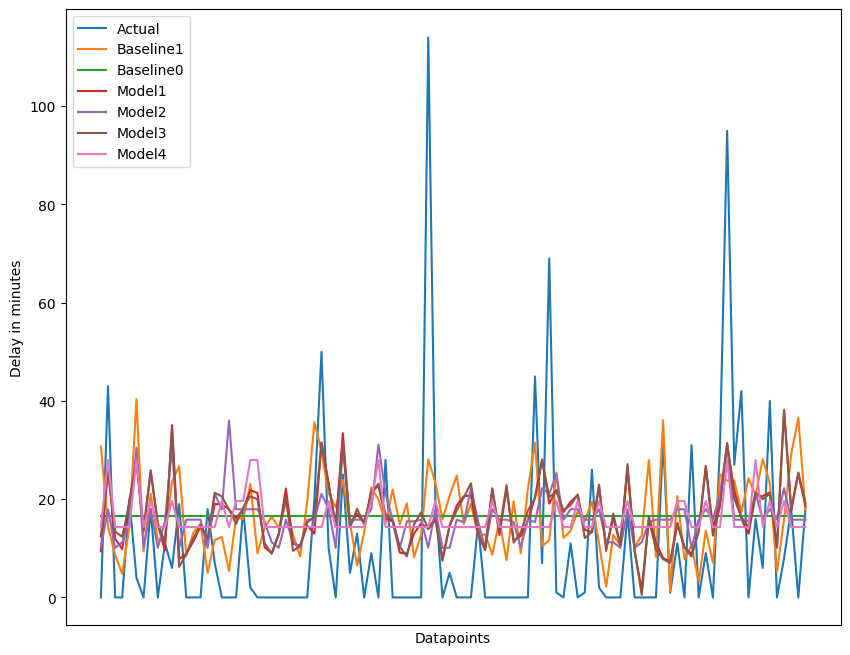

In [164]:
import matplotlib.pyplot as plt
# res = predictions_df.head(100).plot(kind='line',figsize=(10, 8), fontsize=26).get_figure()
# res = df.plot(kind='bar',figsize=(20, 16), fontsize=26).get_figure()
# df.plot()
# ax1 = plt.axes()
# x_axis = ax1.axes.get_xaxis()
# x_axis.set_label_text('foo')
# x_label = x_axis.get_label()
# ##print isinstance(x_label, matplotlib.artist.Artist)
# x_label.set_visible(False)
# plt.plot(predictions_df.head(100))
# # plt.xlabel("")
# plt.figure(figsize=(10, 8))
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# # plt.show()
# plt.savefig('plot2')
# # plt.clf()
# # plt.show()
# # plt.close()

plt.figure(figsize=(14, 12))
# predictions_df.rename(columns={'actual': 'Actual', 'baseline0': 'Baseline0',  'baseline1': 'Baseline1'}, inplace=True)
predictions_df.head(100).plot(kind='line', legend=True, figsize=(10, 8))


# Remove x-tick labels
# plt.xticks([])
plt.ylabel("Delay in minutes")
plt.xlabel("Datapoints")
# Add a legend
plt.legend()

# Save the figure as a PNG file
plt.savefig('output_plot.png')

# Show the plot
plt.show()

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

rf_model = DecisionTreeRegressor(max_depth=4)#(n_estimators=100, random_state=42) #DecisionTreeRegressor(max_depth=4) #RandomForestRegressor(n_estimators=300, random_state=24) #, random_state=42, n_estimators=100 , max_depth = 5
rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)

predictions_df['Model2'] = Y_pred

mse = mean_squared_error(Y_test, Y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 1610.8593621543014
Root Mean Squared Error on Test Set: 40.13551248152067
Mean Absolute Error on Test Set: 19.81244338542557
R-squared: 0.019234536022341042


In [109]:
average_daily_weather = pd.read_csv("data/weather-joined/average_daily_weather.csv")

In [110]:
model_df_encoded.columns

Index(['Origin', 'Dest', 'DepDelayMinutes', 'ArrDelayMinutes',
       'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'WeatherDelay',
       'NASDelay', 'CRSDepHour', 'CRSArrDateTime', 'o_temperature_2m',
       'o_relative_humidity_2m', 'o_dew_point_2m', 'o_apparent_temperature',
       'o_precipitation', 'o_rain', 'o_snowfall', 'o_snow_depth',
       'o_surface_pressure', 'o_cloud_cover', 'o_cloud_cover_low',
       'o_cloud_cover_mid', 'o_cloud_cover_high', 'o_wind_speed_10m',
       'o_wind_speed_100m', 'o_wind_gusts_10m', 'o_shortwave_radiation',
       'o_direct_radiation', 'o_diffuse_radiation',
       'o_direct_normal_irradiance', 'o_terrestrial_radiation',
       'd_temperature_2m', 'd_relative_humidity_2m', 'd_dew_point_2m',
       'd_apparent_temperature', 'd_precipitation', 'd_rain', 'd_snowfall',
       'd_snow_depth', 'd_weather_code', 'd_surface_pressure', 'd_cloud_cover',
       'd_cloud_cover_low', 'd_cloud_cover_mid', 'd_cloud_cover_high',
       'd_wind_speed_10m',

In [113]:
# Feature engineering
def addWeatherFeatures(df):
    df = pd.merge(df, average_daily_weather, left_on=['Origin','month', 'day'], right_on=['airport','month', 'day'], how='left')
    df['o_temp_delta'] = df['o_temperature_2m'] - df['temperature_2m_mean']
    df['o_humidity_delta'] = df['o_relative_humidity_2m'] - df['relative_humidity_2m_mean']
    df['o_dew_point_delta'] = df['o_dew_point_2m'] - df['dew_point_2m_mean']
    df['o_precipitation_delta'] = df['o_precipitation'] - df['precipitation_sum']

    transformed_features = ['o_temperature_2m', 'o_relative_humidity_2m', 'o_dew_point_2m', 'o_precipitation']
    df = df.drop(transformed_features, axis=1)

    return df

In [114]:
feature_df = addWeatherFeatures(model_df_encoded)

In [126]:
feature_df = feature_df.fillna(0)

In [127]:
model1_features = numeric_features + ['weekend', 'year', 'month', 'xhr', 'yhr'] + ['o_weather_code_0.0', 'o_weather_code_1.0', 'o_weather_code_2.0',
       'o_weather_code_3.0', 'o_weather_code_51.0', 'o_weather_code_53.0',
       'o_weather_code_55.0', 'o_weather_code_61.0', 'o_weather_code_63.0',
       'o_weather_code_65.0', 'o_weather_code_71.0', 'o_weather_code_73.0',
       'o_weather_code_75.0']

arrivalFeatures = [ 'd_temperature_2m',
 'd_relative_humidity_2m',
 'd_dew_point_2m',
 'd_apparent_temperature',
 'd_precipitation',
 'd_rain',
 'd_snowfall',
 'd_snow_depth',
 'd_weather_code',
 'd_surface_pressure',
 'd_cloud_cover',
 'd_cloud_cover_low',
 'd_cloud_cover_mid',
 'd_cloud_cover_high',
 'd_wind_speed_10m',
 'd_wind_speed_100m',
 'd_wind_gusts_10m',
 'd_shortwave_radiation',
 'd_direct_radiation',
 'd_diffuse_radiation',
 'd_direct_normal_irradiance',
 'd_terrestrial_radiation',
 'd_day',
 'd_hour']

X = feature_df.drop(['DepDelayMinutes', 'ArrDelayMinutes', 'Dest', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'NASDelay', 'WeatherDelay', 'CRSDepHour', 'CRSArrDateTime', 'Origin', 'airport'] + arrivalFeatures, axis=1)#[model1_features]
Y = feature_df['WeatherDelay'] + feature_df['NASDelay'] #[target_feature]

In [122]:
X.columns

Index(['o_apparent_temperature', 'o_rain', 'o_snowfall', 'o_snow_depth',
       'o_surface_pressure', 'o_cloud_cover', 'o_cloud_cover_low',
       'o_cloud_cover_mid', 'o_cloud_cover_high', 'o_wind_speed_10m',
       'o_wind_speed_100m', 'o_wind_gusts_10m', 'o_shortwave_radiation',
       'o_direct_radiation', 'o_diffuse_radiation',
       'o_direct_normal_irradiance', 'o_terrestrial_radiation', 'weekend',
       'year', 'month', 'day', 'xhr', 'yhr', 'o_weather_code_0.0',
       'o_weather_code_1.0', 'o_weather_code_2.0', 'o_weather_code_3.0',
       'o_weather_code_51.0', 'o_weather_code_53.0', 'o_weather_code_55.0',
       'o_weather_code_61.0', 'o_weather_code_63.0', 'o_weather_code_65.0',
       'o_weather_code_71.0', 'o_weather_code_73.0', 'o_weather_code_75.0',
       'Unnamed: 0', 'temperature_2m_mean', 'relative_humidity_2m_mean',
       'dew_point_2m_mean', 'precipitation_sum', 'rain_sum', 'snowfall_sum',
       'pressure_msl_mean', 'o_temp_delta', 'o_humidity_delta',
       '

In [128]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing  import LabelEncoder
from math import sqrt

model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [130]:
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = sqrt(mse)

predictions_df['Model3'] = Y_pred

mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 1594.7131292545337
Root Mean Squared Error on Test Set: 39.93385943349996
Mean Absolute Error on Test Set: 19.61145291289098
R-squared: 0.029065107190424877


In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

rf_model = DecisionTreeRegressor(max_depth=2) #DecisionTreeRegressor(max_depth=4) #RandomForestRegressor(n_estimators=300, random_state=24) #, random_state=42, n_estimators=100 , max_depth = 5
rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)

predictions_df['Model4'] = Y_pred

rmse = sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 1622.3332737219725
Root Mean Squared Error on Test Set: 40.278198491516136
Mean Absolute Error on Test Set: 20.022797927684532
R-squared: 0.012248689543939761


## Analysis

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [20]:
rc_fonts = {
    
    # "font.family": "serif",
    # "font.size": 20,
    # 'figure.figsize': (5, 3),
    # "text.usetex": True,
    # 'text.latex.preview': True,
    # 'text.latex.preamble': [
    #     r"""
    #     \usepackage{libertine}
    #     \usepackage[libertine]{newtxmath}
    #     """],
}

In [23]:
fm = matplotlib.font_manager
fm._get_fontconfig_fonts.cache_clear()

In [35]:
flist = matplotlib.font_manager.findSystemFonts()
names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
print (names)

['Linux Libertine Mono O', 'Linux Libertine O', 'Lato', 'DejaVu Serif', 'DejaVu Sans Mono', 'Lato', 'DejaVu Serif', 'Linux Biolinum Keyboard O', 'Lato', 'Lato', 'Lato', 'Linux Libertine O', 'Linux Libertine O', 'Lato', 'Linux Biolinum O', 'Lato', 'Linux Biolinum O', 'Lato', 'Lato', 'Lato', 'Lato', 'Lato', 'Linux Libertine Initials O', 'Linux Libertine O', 'Linux Biolinum O', 'Lato', 'DejaVu Sans', 'Lato', 'Lato', 'Linux Libertine O', 'Linux Libertine O', 'Lato', 'DejaVu Sans Mono', 'Linux Libertine Display O', 'Lato', 'DejaVu Sans', 'Lato']


In [38]:
# plt.rcParams.update(rc_fonts)
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams["font.family"] = "LinLibertineO"
plt.rcParams["figure.figsize"] = (16,12)

In [40]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [175]:
def df_stats(df):
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'null_ct': df.isna().sum(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'min': df.min(),
        '1%': df.quantile(0.01),
        '10%': df.quantile(0.1),
        '25%': df.quantile(0.25),
        '50%': df.quantile(0.5),
        '75%': df.quantile(0.75),
        '90%': df.quantile(0.9),
        '99%': df.quantile(0.99),
        'max': df.max(),
        'dtype': df.dtypes,
    })
    return result

In [209]:
df_stats(df17.select_dtypes(include='number'))

,unique,cardinality,null_ct,null_pct,1st_row,random_row,last_row,min,1%,10%,25%,50%,75%,90%,99%,max,dtype
DayOfWeek,False,7,0,0.00,7.000000,6.000000,7.000000,1.000000,1.000000,1.000000,2.000000,4.000000,6.000000,7.000000,7.000000,7.000000,int64
Flight_Number_Reporting_Airline,False,7076,0,0.00,1.000000,5323.000000,2125.000000,1.000000,29.000000,321.000000,736.000000,1679.000000,3064.000000,5073.000000,6487.000000,8402.000000,int64
OriginAirportID,False,320,0,0.00,12478.000000,10397.000000,12266.000000,10135.000000,10299.000000,10693.000000,11292.000000,12892.000000,14057.000000,14771.000000,15323.000000,16218.000000,int64
DestAirportID,False,320,0,0.00,12892.000000,15249.000000,13244.000000,10135.000000,10299.000000,10693.000000,11292.000000,12892.000000,14057.000000,14771.000000,15304.000000,16218.000000,int64
CRSDepTime,False,1330,0,0.00,800.000000,1530.000000,2000.000000,1.000000,520.000000,700.000000,912.000000,1323.000000,1735.000000,2010.000000,2250.000000,2359.000000,int64
DepTime,False,1440,80308,1.42,831.000000,1526.000000,2000.000000,1.000000,501.000000,654.000000,914.000000,1327.000000,1743.000000,2022.000000,2305.000000,2400.000000,float64
DepDelayMinutes,False,1417,0,0.00,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,35.000000,180.000000,2755.000000,float64
CRSArrTime,False,1435,0,0.00,1142.000000,1641.000000,2135.000000,1.000000,35.000000,825.000000,1103.000000,1520.000000,1920.000000,2151.000000,2350.000000,2359.000000,int64
ArrTime,False,1440,84674,1.49,1209.000000,1625.000000,2128.000000,1.000000,23.000000,806.000000,1050.000000,1510.000000,1918.000000,2151.000000,2344.000000,2400.000000,float64
ArrDelayMinutes,False,1405,95211,1.68,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,35.000000,180.000000,2189.000000,float64


In [214]:
df17[(df17['DepDelayMinutes'] >= 1500) | (df17['ArrDelayMinutes'] >= 1500)].describe()

,DayOfWeek,Flight_Number_Reporting_Airline,OriginAirportID,DestAirportID,CRSDepTime,DepTime,DepDelayMinutes,CRSArrTime,ArrTime,ArrDelayMinutes,Cancelled,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSDepHour,CRSArrHour,o_temperature_2m,o_relative_humidity_2m,o_dew_point_2m,o_apparent_temperature,o_precipitation,o_rain,o_snowfall,o_snow_depth,o_weather_code,o_surface_pressure,o_cloud_cover,o_cloud_cover_low,o_cloud_cover_mid,o_cloud_cover_high,o_wind_speed_10m,o_wind_speed_100m,o_wind_gusts_10m,o_shortwave_radiation,o_direct_radiation,o_diffuse_radiation,o_direct_normal_irradiance,o_terrestrial_radiation,o_hour,d_temperature_2m,d_relative_humidity_2m,d_dew_point_2m,d_apparent_temperature,d_precipitation,d_rain,d_snowfall,d_snow_depth,d_weather_code,d_surface_pressure,d_cloud_cover,d_cloud_cover_low,d_cloud_cover_mid,d_cloud_cover_high,d_wind_speed_10m,d_wind_speed_100m,d_wind_gusts_10m,d_shortwave_radiation,d_direct_radiation,d_diffuse_radiation,d_direct_normal_irradiance,d_terrestrial_radiation,d_hour
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,43.000000,42.000000,46.0,46.000000,46.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.0,42.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,43.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,3.543478,2428.217391,12438.000000,12421.934783,1098.239130,1371.739130,1668.282609,1397.239130,1537.046512,1649.690476,0.0,0.086957,171.173913,167.523810,129.761905,1264.452381,83.833333,156.071429,0.0,145.333333,10.347826,14.913043,54.564174,72.772313,44.717000,51.484217,0.006505,0.006419,0.000599,0.049594,13.978261,986.472026,41.473914,20.000000,31.369565,37.500000,7.649846,12.626317,15.527698,92.652174,58.434783,34.217391,98.259106,176.502216,10.347826,62.198776,66.683248,49.542037,60.030274,0.007446,0.007360,0.000599,0.007132,13.869565,998.666011,38.900000,26.260870,17.804348,25.717391,9.373857,13.436622,18.683813,271.130435,195.630435,75.500000,318.752235,449.733828,14.913043
std,2.105089,2102.378758,1447.428632,1308.459338,370.960985,436.247556,221.697658,444.851545,489.532428,149.122881,0.0,0.284885,87.670926,86.423867,83.933426,633.765795,381.388600,456.014034,0.0,393.433086,3.760717,5.439878,17.757802,19.962414,18.335336,22.246392,0.015796,0.015821,0.004063,0.156260,24.181250,46.847589,40.143949,32.604703,40.370153,43.614345,5.681894,8.883529,11.097121,214.100311,160.881827,77.623855,227.419108,371.088331,3.760717,18.749941,20.862040,19.106001,23.124638,0.025477,0.025496,0.004063,0.030865,23.765155,23.062974,37.102105,37.253745,30.145292,35.136978,4.541434,6.939349,8.667680,302.990914,251.350429,77.556216,343.486140,438.479138,5.439878
min,1.000000,43.000000,10135.000000,10397.000000,535.000000,123.000000,1493.000000,705.000000,16.000000,1472.000000,0.0,0.000000,65.000000,52.000000,30.000000,0.000000,0.000000,0.000000,0.0,0.000000,5.000000,0.000000,11.613199,22.137040,3.513199,3.812921,0.000000,0.000000,0.000000,0.000000,0.000000,807.727200,0.000000,0.000000,0.000000,0.000000,0.806562,0.316360,3.131800,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,17.944700,22.318884,8.205799,7.460674,0.000000,0.000000,0.000000,0.000000,0.000000,879.518300,0.000000,0.000000,0.000000,0.000000,0.806562,1.000417,3.802900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.250000,609.500000,11189.000000,11298.000000,807.500000,1055.250000,1531.250000,978.750000,1282.000000,1541.250000,0.0,0.000000,97.000000,97.500000,59.250000,1054.250000,0.000000,0.000000,0.0,0.000000,7.250000,12.00000

In [37]:
corr_matrix = model_df_encoded.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#[['WeatherDelay']].sort_values(by='WeatherDelay', ascending=False)
plt.figure(figsize=(6, 20))
sns.heatmap(corr_matrix[['WeatherDelay']].sort_values(by='WeatherDelay', ascending=False), annot=True, cmap='BrBG', linewidths=0.5, vmin=-1, vmax=1);

findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not found.
findfont: Font family 'Linux Libertine O' not 

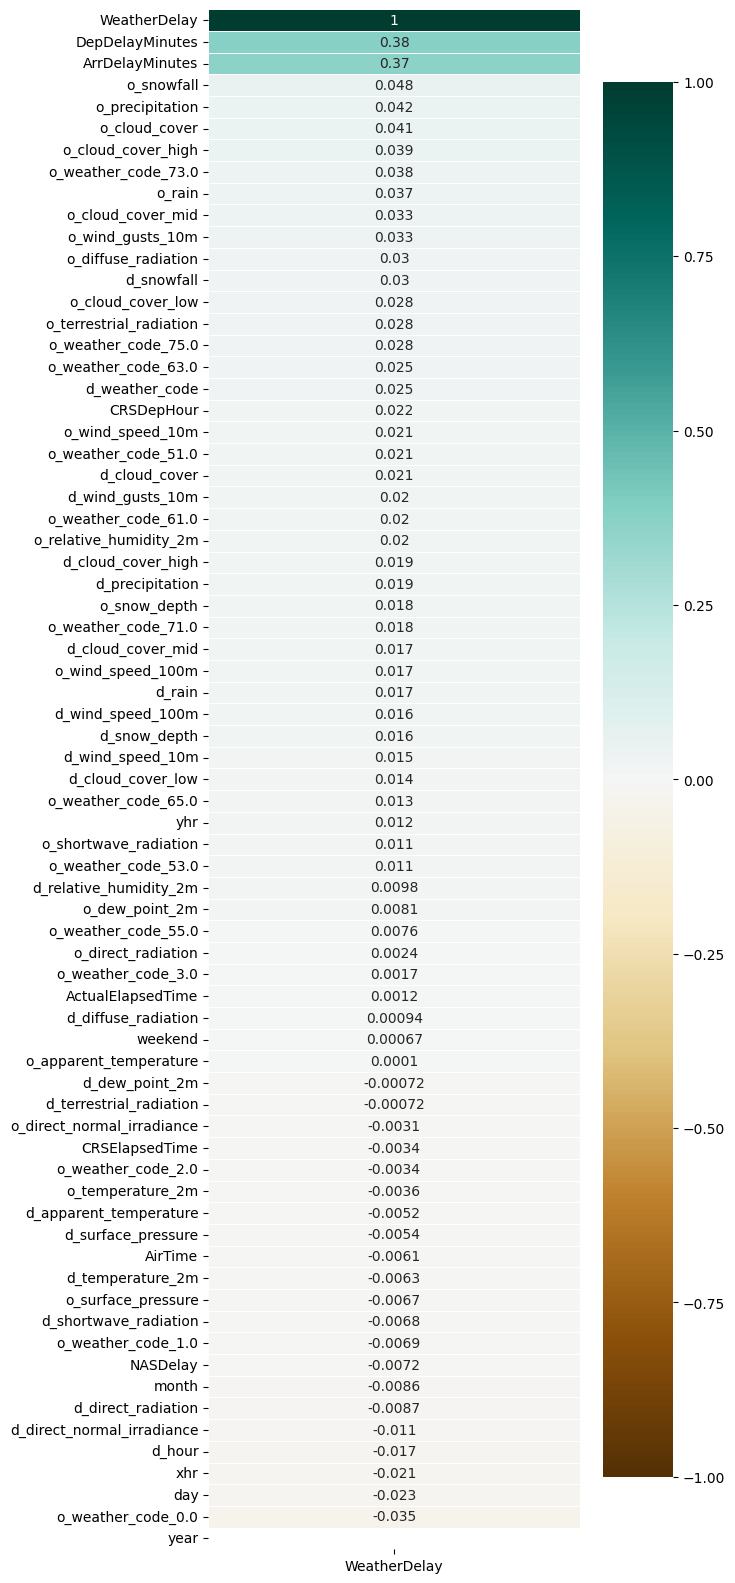

In [27]:
plt.show()

In [28]:
arrivalFeatures = [ 'd_temperature_2m',
 'd_relative_humidity_2m',
 'd_dew_point_2m',
 'd_apparent_temperature',
 'd_precipitation',
 'd_rain',
 'd_snowfall',
 'd_snow_depth',
 'd_weather_code',
 'd_surface_pressure',
 'd_cloud_cover',
 'd_cloud_cover_low',
 'd_cloud_cover_mid',
 'd_cloud_cover_high',
 'd_wind_speed_10m',
 'd_wind_speed_100m',
 'd_wind_gusts_10m',
 'd_shortwave_radiation',
 'd_direct_radiation',
 'd_diffuse_radiation',
 'd_direct_normal_irradiance',
 'd_terrestrial_radiation',
 'd_day',
 'd_hour']

In [267]:
df17.dtypes

DayOfWeek                            int64
FlightDate                          object
IATA_CODE_Reporting_Airline         object
Tail_Number                         object
Flight_Number_Reporting_Airline      int64
OriginAirportID                      int64
Origin                              object
OriginState                         object
DestAirportID                        int64
Dest                                object
DestState                           object
CRSDepTime                           int64
DepTime                            float64
DepDelayMinutes                    float64
CRSArrTime                           int64
ArrTime                            float64
ArrDelayMinutes                    float64
Cancelled                            int64
CancellationCode                    object
Diverted                             int64
CRSElapsedTime                     float64
ActualElapsedTime                  float64
AirTime                            float64
CarrierDela

In [29]:
model_df_dropped['o_day'] = model_df_dropped['o_day'].astype('datetime64[ns]')
model_df_dropped['month'] = model_df_dropped['o_day'].dt.month

In [104]:
# model_df_dropped.columns

to_drop = ['DayOfWeek', 'Origin', 'Dest', 
       'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'CRSDepHour', 'CRSArrDateTime', 'Dest', 'CRSElapsedTime', 'o_hour',
      'CRSArrDateTime', 'Origin', 'month', 'NASDelay', 'WeatherDelay', 'o_weather_code', 'o_diffuse_radiation', 'o_direct_radiation', 'o_shortwave_radiation', 'o_direct_normal_irradiance', 'o_wind_speed_100m', 'o_apparent_temperature', 'o_cloud_cover_high'] + arrivalFeatures

In [60]:
jfk_delay = model_df_dropped[(model_df_dropped['Origin'] == 'JFK') & (model_df_dropped['month'] == 1)]
jfk_delay = jfk_delay.drop(to_drop, axis=1)
jfk_delayed = jfk_delay[(jfk_delay['WeatherDelay'] > 0) | (jfk_delay['NASDelay'] > 0)]
print(jfk_delayed[jfk_delayed['o_snowfall'] == 0].shape)
# jfk_cancelled = jfk_delay[jfk_delay['Cancelled'] == 1]


(1236, 28)


In [ ]:
corr_matrix = jfk_delayed.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#[['WeatherDelay']].sort_values(by='WeatherDelay', ascending=False)
plt.figure(figsize=(6, 20))
sns.heatmap(corr_matrix[['ArrDelayMinutes']].sort_values(by='ArrDelayMinutes', ascending=False), annot=True, cmap='BrBG', linewidths=0.5, vmin=-1, vmax=1);

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

airport = "JFK"
months = [1, 5, 10]
mlabels = ["January", "May", "October"]

plt.title("Correlation heatmap for months: January, May and October")

for m in range(len(months)):
    jfk_delay1 = model_df_dropped[(model_df_dropped['Origin'] == airport) & (model_df_dropped['month'] == months[m])]
    jfk_delayed1 = jfk_delay1[(jfk_delay1['WeatherDelay'] > 0) | (jfk_delay1['NASDelay'] > 0)]
    jfk_delayed1 = jfk_delayed1.drop(to_drop, axis=1)
    corr_matrix1 = jfk_delayed1.corr(numeric_only = True).fillna(0.0012)
    # print(corr_matrix1.isnull().sum())
    sns.heatmap(corr_matrix1[['ArrDelayMinutes']].sort_values(by='ArrDelayMinutes', ascending=False), annot=True, cmap='BrBG', cbar=False, linewidths=0.5, vmin=-1, vmax=1, ax=axes[m]);
    axes[m].set_title(f'{mlabels[m]}')

plt.tight_layout()
# plt.show()
plt.savefig("JFK-3months.png")

In [145]:
temp2 = [ "o_rain", 'o_wind_speed_100m', 'o_apparent_temperature',  'o_direct_normal_irradiance','o_weather_code', 'o_direct_radiation',  'o_shortwave_radiation', 'o_cloud_cover_high']
temp = [ 'o_diffuse_radiation' ]

to_drop2 = ['DayOfWeek', 'Origin', 'Dest', 
       'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'CRSDepHour', 'CRSArrDateTime', 'Dest', 'CRSElapsedTime', 'o_hour',
      'CRSArrDateTime', 'Origin', 'month', 'NASDelay', 'WeatherDelay'] + arrivalFeatures +temp2

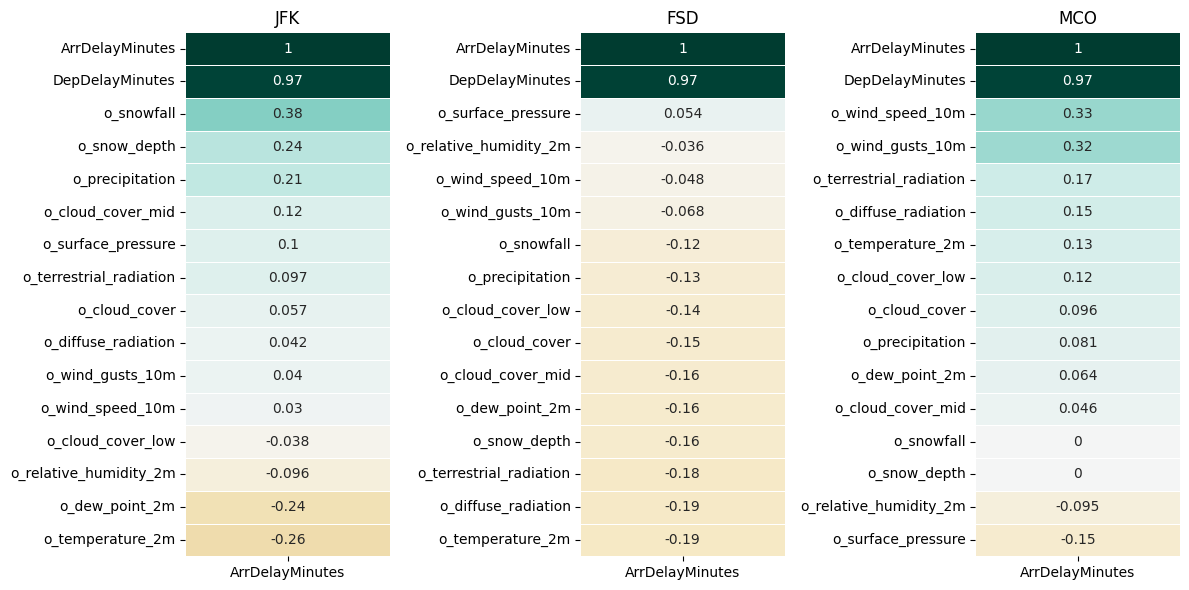

In [154]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

airports = ["JFK", "FSD", "MCO"] #"DEN", "SFO", "SAN", 
month = 1
# labels = ["January", "May", "October"]

plt.title("Correlation heatmap for months: January, May and October")

for a in range(len(airports)):
    jfk_delay1 = model_df_dropped[(model_df_dropped['Origin'] == airports[a]) & (model_df_dropped['month'] == month)]
    jfk_delayed1 = jfk_delay1[(jfk_delay1['WeatherDelay'] > 0) | (jfk_delay1['NASDelay'] > 0)]
    jfk_delayed1 = jfk_delayed1.drop(to_drop2, axis=1)
    corr_matrix1 = jfk_delayed1.corr(numeric_only = True).fillna(0)
    sns.heatmap(corr_matrix1[['ArrDelayMinutes']].sort_values(by='ArrDelayMinutes', ascending=False), annot=True, cmap='BrBG', cbar=False, linewidths=0.5, vmin=-1, vmax=1, ax=axes[a]);
    axes[a].set_title(f'{airports[a]}')

plt.tight_layout()
fig1 = plt.gcf()
# plt.show()
# plt.show()
fig1.savefig("Jan-3loc.png")

In [ ]:
for weather_ft in arrivalFeatures:
    
    df17.plot.scatter(x='WeatherDelay',
                y=weather_ft,
               s=.05);